In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import os
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.autograd import Variable

In [2]:
train_data_raw = pd.read_csv('./Dataset/sign_mnist_train.csv', sep=",")
test_data_raw = pd.read_csv('./Dataset/sign_mnist_test.csv', sep=",")

In [3]:
train_labels = train_data_raw['label']
train_data_raw.drop('label', axis=1, inplace=True) # dropping the label column

test_labels = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True) # dropping the label column

In [4]:
train_data = train_data_raw.values
train_labels = train_labels.values

test_data = test_data_raw.values
test_labels = test_labels.values

In [5]:
set(train_labels) #No  9=J or 25=Z because of gesture motions 

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24}

In [6]:
dim=28

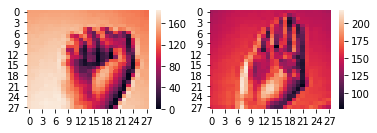

In [7]:
pixels = train_data[20].reshape(dim, dim)
plt.subplot(221)
sns.heatmap(data=pixels)

pixels = train_data[30].reshape(dim, dim)
plt.subplot(222)
sns.heatmap(data=pixels)

In [8]:
reshaped_train = []
for i in train_data:
    reshaped_train.append(i.reshape(1, dim, dim))
train_data = np.array(reshaped_train)

reshaped_test = []
for i in test_data:
    reshaped_test.append(i.reshape(1, dim, dim))
test_data = np.array(reshaped_train)

In [9]:
train_x = torch.FloatTensor(train_data)
train_y = torch.LongTensor(train_labels.tolist())

test_x = torch.FloatTensor(train_data)
test_y = torch.LongTensor(train_labels.tolist())

In [80]:
alph = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
        10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
        18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y' }

In [11]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,20,3)
        self.conv3 = nn.Conv2d(20,30,3)
        
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(0.2)
        
        self.fc1 = nn.Linear(30*3*3, 270)
        self.fc2 = nn.Linear(270,26)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = x.view(-1, 30 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.softmax(F.relu(self.fc2(x)))
        
        return(x)
        
    def test(self, predictions,labels):
        self.eval()
        correct = 0
        for p,l in zip(predictions,labels):
            if p==l:
                correct+=1
        acc = correct/len(predictions)
        return(acc, correct, len(predictions))
    
    def evaluate(self, predictions,labels):
        correct = 0
        for p,l in zip(predictions,labels):
            if p==l:
                correct+=1
        acc = correct/len(predictions)
        return(acc)

In [12]:
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    model = Network().cuda()

In [13]:
summary(model, (1,dim,dim)) #takes the model and the input tensor shape, displays the output shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
         MaxPool2d-2           [-1, 10, 13, 13]               0
            Conv2d-3           [-1, 20, 11, 11]           1,820
         MaxPool2d-4             [-1, 20, 5, 5]               0
            Conv2d-5             [-1, 30, 3, 3]           5,430
         Dropout2d-6             [-1, 30, 3, 3]               0
            Linear-7                  [-1, 270]          73,170
            Linear-8                   [-1, 26]           7,046
        LogSoftmax-9                   [-1, 26]               0
Total params: 87,566
Trainable params: 87,566
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.33
Estimated Total Size (MB): 0.43
---------------------------------------------

In [14]:
epochs = 50
batch_size = 100
learning_rate = 0.001

In [15]:
optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.007)
criterion = nn.CrossEntropyLoss()

In [ ]:
# def train(epochs, model, optimizer, criterion, use_cuda):
#     loss_log = []
#     acc_log = []

#     for epoch in range(1, epochs+1):
#         train_loss = 0.0
        
#         model.train()
        
#         for index, data in enumerate(train_data):
#             target = train_labels[index]
            
#             if use_cuda:
#                 data.cuda()
# #                 target.cuda()
                
#             optimizer.zero_grad()
#             output = model(data)
#             loss = criterion(output, target)
#             loss.backward()
#             optimizer.step()
            
#             if index%1000==0:
#                 loss_log.append(loss.item())
#                 acc_log.append(net.evaluate(torch.max(net(Variable(test_x[:500])).data, 1)[1], test_y[:500]))
            
            
#             # print training/validation statistics 
#             print('Epoch: {} \tTraining Loss: {:.6f} '.format(
#                 epoch, 
#                 train_loss
#                 ))

            
#     # return trained model
#     return model

In [ ]:
# # train the model
# model_scratch = train(epochs, model, optimizer, criterion, use_cuda)

In [16]:
loss_log = []
acc_log = []

for e in range(epochs):
    for i in range(0, train_x.shape[0], 100):
        x_mini = train_x[i:i + 100] 
        y_mini = train_y[i:i + 100] 
        
        if use_cuda:
            x_mini = x_mini.cuda()
            y_mini = y_mini.cuda()
            test_x = test_x.cuda()
            test_y = test_y.cuda()
        
        optimizer.zero_grad()
        net_out = model(Variable(x_mini))
        
        loss = criterion(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(model.evaluate(torch.max(model(Variable(test_x[:500])).data, 1)[1], test_y[:500]))
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 3.171004
Epoch: 2 - Loss: 2.928471
Epoch: 3 - Loss: 2.747584
Epoch: 4 - Loss: 2.216086
Epoch: 5 - Loss: 1.716320
Epoch: 6 - Loss: 1.344784
Epoch: 7 - Loss: 0.993603
Epoch: 8 - Loss: 0.987541
Epoch: 9 - Loss: 0.759723
Epoch: 10 - Loss: 0.620595
Epoch: 11 - Loss: 0.631502
Epoch: 12 - Loss: 0.622687
Epoch: 13 - Loss: 0.432498
Epoch: 14 - Loss: 0.470578
Epoch: 15 - Loss: 0.418309
Epoch: 16 - Loss: 0.399430
Epoch: 17 - Loss: 0.320283
Epoch: 18 - Loss: 0.349432
Epoch: 19 - Loss: 0.215379
Epoch: 20 - Loss: 0.231829
Epoch: 21 - Loss: 0.165634
Epoch: 22 - Loss: 0.174026
Epoch: 23 - Loss: 0.198509
Epoch: 24 - Loss: 0.165262
Epoch: 25 - Loss: 0.117323
Epoch: 26 - Loss: 0.219265
Epoch: 27 - Loss: 0.122914
Epoch: 28 - Loss: 0.127848
Epoch: 29 - Loss: 0.088561
Epoch: 30 - Loss: 0.069623
Epoch: 31 - Loss: 0.089962
Epoch: 32 - Loss: 0.135089
Epoch: 33 - Loss: 0.091101
Epoch: 34 - Loss: 0.042823
Epoch: 35 - Loss: 0.107452
Epoch: 36 - Loss: 0.066240
Epoch: 37 - Loss: 0.106593
Epoch: 38 

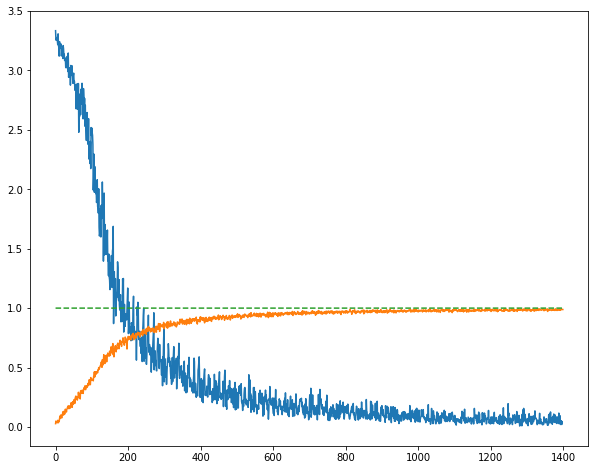

In [17]:
plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)), linestyle='dashed')
plt.show()

In [18]:
predictions = model(Variable(test_x))
accuracy, correct, total = model.test(torch.max(predictions.data, 1)[1], test_y)

In [19]:
print("Accuracy = " + str(accuracy) + " ("+str(correct)+"/"+str(total)+")")

Accuracy = 0.9848479329812421 (27039/27455)


In [ ]:
# def predict(img_path):
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = cv2.resize(img, (dim,dim))
#     plt.imshow(img, cmap="gray")
#     img = img.reshape(1,1, dim, dim)
#     np_img = np.array(img)
#     input_img = torch.FloatTensor(np_img)
    
#     if use_cuda:
#         input_img = input_img.cuda()
        
#     pred = model(Variable(input_img))
#     pred = torch.max(pred.data, 1)[1].cpu().numpy()[0]
#     return pred

In [85]:
def predictor(img_path):  
#     img = cv2.imread(img_path)
#     grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     res = cv2.resize(img, dsize=(28, 28))
#     test_img = torch.FloatTensor(grey)
#     predictions = model(Variable(test_img))
#     pred = torch.max(predictions.data, 1)[1]
    
    img = cv2.imread(img_path)
    res = cv2.resize(img, dsize=(28, 28))
#     res = cv2.resize(img, dsize=(28, 28), interpolation = cv2.INTER_CUBIC)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

    res1 = np.reshape(res, (1, 1, 28, 28)) / 255
    res1 = torch.from_numpy(res1)
    res1 = res1.type(torch.FloatTensor)
    if use_cuda:
        res1 = res1.cuda() 
    out = model(res1)
    # Probabilidades
    probs, label = torch.topk(out, 25)
    probs = torch.nn.functional.softmax(probs, 1)

    pred = out.max(1, keepdim=True)[1].cpu().numpy()[0]

    if float(probs[0,0]) < 0.4:
        texto_mostrar = 'Sign not detected'
    else:
        texto_mostrar = signs[str(int(pred))] + ': ' + '{:.2f}'.format(float(probs[0,0])) + '%'
        
    return pred

In [89]:
prediction = predictor('Inference_Images/a.jpg')
lab = 'A'

In [90]:
prediction[0] 

10

In [91]:
print("Prediction: {}".format(alph[prediction[0]]))
print("Actual Label: {}".format(lab))

Prediction: K
Actual Label: C


In [ ]:
# pixels = cv2.imread('./c.jpg').reshape(28, 28)
# plt.subplot(223)
# sns.heatmap(data=pixels)
# lab = 'c'
# test_sample = torch.FloatTensor([pixels.reshape(1, 28, 28).tolist()])
# pred = model(Variable(input_img))
# print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
# print("Actual Label: {}".format(lab))
